# HW2

#### **Name:** Eric Liu

#### **Dataset:** usina_with_outliers.csv



In [4]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

np.set_printoptions(precision=4, suppress=True)


# DATA LOADING

In [5]:
DATA_PATH = "usina_with_outliers.csv"
df = pd.read_csv(DATA_PATH)
display(df.head())

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())



,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90



Summary statistics:


,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.618518,54.250021,1013.288871,73.308978,454.407820
std,8.256412,13.993655,6.636609,16.094499,18.760047
min,-39.174839,-38.397358,959.607298,-53.091613,327.528030
25%,13.480000,41.670000,1009.077500,63.227500,439.730000
50%,20.320000,52.080000,1012.950000,74.955000,451.620000
75%,25.732500,66.540000,1017.320000,84.882500,468.530000
max,77.344839,155.117358,1064.772702,187.691613,590.091970



Missing values per column:


,0
AT,0
V,0
AP,0
RH,0
PE,0


# Helper function

This function scales the data and fits OLS, returning model and diagnostics.

In [6]:
def fit_ols_diagnostics(X, y):
    """Fit OLS and return (model, diagnostics dataframe).

    Parameters
    ----------
    X : array-like, shape (n,) or (n, p)
        Feature matrix (without intercept column).
    y : array-like, shape (n,)
        Target vector.
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Add intercept column for statsmodels
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()

    infl = OLSInfluence(model)
    diag = pd.DataFrame({
        "y": y,
        "y_hat": model.fittedvalues,
        "residual": model.resid,
        "leverage_hii": infl.hat_matrix_diag,   # diagonal of Hat matrix H
        "cooks_D": infl.cooks_distance[0]
    })
    return model, diag


# Q1. Compute Cooks Distance

The below code, using the standard threshold of 4/n computes outliers that should be removed. I choose to use the linear model since Cook's distance formula is defined from the OLS model, and I didn't want to reduce the outlier influence on the model for analysis. I also used statsmodels for analysis since it has a more direct method for calculating Cook's distance.

In [7]:
x = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']
model_full, diag_full = fit_ols_diagnostics(x, y)

print(model_full.summary())

# Show the top points by Cook's distance
n = len(x)
threshold = 4 / n

# Fix: Use pd.concat to merge the diagnostic table with the feature DataFrame x
diag_table = pd.concat([diag_full, x], axis=1)
diag_table["flag_D_gt_4_over_n"] = diag_table["cooks_D"] > threshold

print(f"Cook's distance heuristic threshold 4/n = {threshold:.3f}")
diag_table.sort_values("cooks_D", ascending=False)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     4416.
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:56:13   Log-Likelihood:                -36621.
No. Observations:                9568   AIC:                         7.325e+04
Df Residuals:                    9563   BIC:                         7.329e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.7845     19.524      2.447      0.0

,y,y_hat,residual,leverage_hii,cooks_D,AT,V,AP,RH,flag_D_gt_4_over_n
4228,532.89197,367.627618,165.264352,0.027485,1.283760e+00,73.964839,155.117358,1047.682702,171.881613,True
49,370.64803,515.833750,-145.185720,0.027817,1.003422e+00,-35.324839,116.357358,1064.772702,164.891613,True
875,541.43197,408.524788,132.907182,0.032505,9.921334e-01,67.814839,-10.197358,984.647298,168.221613,True
5922,373.10803,481.504793,-108.396763,0.041859,8.665161e-01,-35.034839,114.407358,979.907298,-7.931613,True
2538,364.32803,559.133964,-194.805934,0.013496,8.512237e-01,-29.834839,-33.967358,1042.892702,-16.301613,True
...,...,...,...,...,...,...,...,...,...,...
3893,441.00000,440.997993,0.002007,0.000596,3.889632e-12,27.940000,63.070000,1010.750000,38.570000,False
3390,451.29000,451.291688,-0.001688,0.000345,1.588981e-12,18.340000,65.940000,1013.270000,85.420000,False
2699,460.19000,460.188889,0.001111,0.000406,8.105201e-13,15.790000,50.880000,1014.580000,99.900000,False
7072,475.21000,475.210337,-0.000337,0.000423,7.765671e-14,9.820000,36.180000,1019.180000,65.800000,False


## Cleaning Data

This portion cleans the data of all values that are above the threshold of 4/n.

In [8]:
flag_remove = diag_table["flag_D_gt_4_over_n"] == False
x_clean = x[flag_remove]
y_clean = y[flag_remove]

model_clean, diag_clean = fit_ols_diagnostics(x_clean, y_clean)

coef_full = np.asarray(model_full.params).reshape(-1)
coef_clean = np.asarray(model_clean.params).reshape(-1)

print(f"Full-data:   b0 = {coef_full[0]:.4f}, b1 = {coef_full[1]:.4f}")
print(f"Cleaned-data: b0 = {coef_clean[0]:.4f}, b1 = {coef_clean[1]:.4f}")

df_clean = pd.concat([x_clean, y_clean], axis=1)
display(df_clean.head())

Full-data:   b0 = 47.7845, b1 = -1.1528
Cleaned-data: b0 = 440.9993, b1 = -1.9546


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [9]:
df_clean.to_csv('usina.csv', index=False)

# Q2. Helper Functions

Taken from HW1, to prepare data to for train / test.

In [10]:
TARGET_COL = "PE"

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()




In [65]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
def fit_and_report_basic_models(df_in, scenario_prefix):
    models = {
        "Linear": LinearRegression(),
        "Ridge(alpha=0.01)": Ridge(alpha=0.01, random_state=42),
        "Ridge(alpha=0.1)": Ridge(alpha=0.1, random_state=42),
        "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=42),
        "Ridge(alpha=10)": Ridge(alpha=10, random_state=42),
        "Ridge(alpha=100)": Ridge(alpha=100, random_state=42),
        "Lasso(alpha=0.01)": Lasso(alpha=0.01, max_iter=50000, random_state=42),
        "Lasso(alpha=0.1)": Lasso(alpha=0.1, max_iter=50000, random_state=42),
        "Lasso(alpha=1.0)": Lasso(alpha=1.0, max_iter=50000, random_state=42),
        "Lasso(alpha=10)": Lasso(alpha=10, max_iter=50000, random_state=42),
        "Lasso(alpha=100)": Lasso(alpha=100, max_iter=50000, random_state=42),

    }

    X, y = prepare_xy(df_in, target_col=TARGET_COL)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.3, random_state=42)

    rows = []

    Xt_tr, Xt_te = X_train, X_test
    yt_tr = y_train

    for name, model in models.items():
        model.fit(Xt_tr, yt_tr.ravel())
        pred_tr = model.predict(Xt_tr).reshape(-1,1)
        pred_te = model.predict(Xt_te).reshape(-1,1)

        pred_tr_eval = pred_tr
        pred_te_eval = pred_te
        yt_tr_eval = y_train
        yt_te_eval = y_test

        mtr = compute_metrics(yt_tr_eval, pred_tr_eval)
        mte = compute_metrics(yt_te_eval, pred_te_eval)

        rows.append({
            "Scenario": scenario_prefix,
            "Model": name,
            **{f"train_{k}": v for k,v in mtr.items()},
            **{f"test_{k}": v for k,v in mte.items()},
        })
    return pd.DataFrame(rows)

all_results = []

# Run models for uncleaned data
uncleaned_results = fit_and_report_basic_models(df, "PE vs. Plant Characteristics: Uncleaned")
all_results.append(uncleaned_results)

# Run models for cleaned data
cleaned_results = fit_and_report_basic_models(df_clean, "PE vs. Plant Characteristics: Cleaned")
all_results.append(cleaned_results)

# Concatenate all results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)
display(final_results_df.sort_values("test_MSE"))



/tmp/ipython-input-896742646.py:28: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(Xt_tr, yt_tr.ravel())
/tmp/ipython-input-896742646.py:28: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(Xt_tr, yt_tr.ravel())
/tmp/ipython-input-896742646.py:28: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(Xt_tr, yt_tr.ravel())
/tmp/ipython-input-896742646.py:28: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(Xt_tr, yt_tr.ravel())
/tmp/ipython-input-896742646.py:28: FutureWarning: Series.ra

,Scenario,Model,train_MSE,train_MAE,train_R^2,test_MSE,test_MAE,test_R^2
18,PE vs. Plant Characteristics: Cleaned,Lasso(alpha=0.1),19.865263,3.596855,0.931367,20.392600,3.624890,0.930316
16,PE vs. Plant Characteristics: Cleaned,Ridge(alpha=100),19.864758,3.596742,0.931369,20.394626,3.624880,0.930310
15,PE vs. Plant Characteristics: Cleaned,Ridge(alpha=10),19.864672,3.596430,0.931369,20.396549,3.624783,0.930303
17,PE vs. Plant Characteristics: Cleaned,Lasso(alpha=0.01),19.864675,3.596368,0.931369,20.396738,3.624754,0.930302
14,PE vs. Plant Characteristics: Cleaned,Ridge(alpha=1.0),19.864671,3.596400,0.931369,20.396750,3.624774,0.930302
13,PE vs. Plant Characteristics: Cleaned,Ridge(alpha=0.1),19.864671,3.596397,0.931369,20.396770,3.624773,0.930302
12,PE vs. Plant Characteristics: Cleaned,Ridge(alpha=0.01),19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
11,PE vs. Plant Characteristics: Cleaned,Linear,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
19,PE vs. Plant Characteristics: Cleaned,Lasso(alpha=1.0),19.929852,3.605523,0.931144,20.414755,3.631153,0.930241
20,PE vs. Plant Characteristics: Cleaned,Lasso(alpha=10),25.685683,4.086632,0.911258,26.157253,4.120464,0.910618


## Q2 Discussion

**1. Do outliers change train error? Test error?**

Outliers seem to increase train error and test error generally. For each alpha value, its cleaned dataset would always perform better (lower test_MSE, train_MSE, better R^2) than its uncleaned counterpart.

**2. Which dataset (with outliers vs without outliers) shows better generalization?**

Comparing datasets, the non-outliers model had better generalization, with lower test error overall significantly. This suggests the cleaned dataset better captures the true signal rather than noise or extreme leverage points.

**3. Do Ridge/Lasso appear to help relative to standard linear regression?**

Yes, they seem to help a lot. It can be seen as the top 7 best performing models are of these variations. This is because they reduce variance and lead to more stable coefficients, resulting in improved generalization on the test set.

# Q3 & Q4. Reliability of Coefficients

Below, I reinstantiate X and Y (because previously they were within a function, yes I know very scuffed), and define helper functions to standardize and unstandardize coefficients.

In [12]:
X = df_clean.drop(columns=[TARGET_COL]).copy()
y = df_clean[TARGET_COL].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)


# === Create unscaled and scaled versions (scale BOTH X and y) ===
# Unscaled
X_train_un = X_train.values
X_test_un  = X_test.values
y_train_un = y_train
y_test_un  = y_test

# Scaled (fit scalers only on TRAIN)
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_sc = x_scaler.fit_transform(X_train_un)
X_test_sc  = x_scaler.transform(X_test_un)

y_train_sc = y_scaler.fit_transform(y_train_un)
y_test_sc  = y_scaler.transform(y_test_un)

feature_names = X.columns.tolist()

def standardized_coef_unscaled(beta, X_train_raw, y_train_raw):
    """Standardized coefficients (effect size) for unscaled data:
       beta_std = beta * (std(X)/std(y)), computed using TRAIN statistics.
    """
    std_x = np.std(X_train_raw, axis=0, ddof=0)
    std_y = float(np.std(y_train_raw, axis=0, ddof=0))
    std_y = std_y if std_y > 0 else 1.0
    return beta * (std_x / std_y)

def convert_scaled_coef_to_original(beta_scaled, intercept_scaled, x_scaler: StandardScaler, y_scaler: StandardScaler):
    """Convert coefficients from (X_scaled, y_scaled) space to original units."""
    x_mean = x_scaler.mean_
    x_std  = x_scaler.scale_
    y_mean = float(y_scaler.mean_)
    y_std  = float(y_scaler.scale_)

    beta_orig = (y_std * beta_scaled) / x_std
    intercept_orig = y_mean + y_std * intercept_scaled - np.sum((y_std * beta_scaled * x_mean) / x_std)
    return beta_orig, intercept_orig

The code snipped below computes and displays the coefficients and t-statistics after running the model. I used a Linear Regression model since it is the most generic and all the statistical methods are based on OLS. For reliability, it doesn't matter whether or not I compute the t-statistic based on scaled or unscaled data since it is scaling invariant.

In [13]:
def linear_with_ols_reports():
    reports = {}
    for variant in ["unscaled", "scaled"]:
        if variant == "unscaled":
            Xt_tr, Xt_te = X_train_un, X_test_un
            yt_tr = y_train_un
        else:
            Xt_tr, Xt_te = X_train_sc, X_test_sc
            yt_tr = y_train_sc

        lr = LinearRegression()
        lr.fit(Xt_tr, yt_tr.ravel())

        pred_tr = lr.predict(Xt_tr).reshape(-1,1)
        pred_te = lr.predict(Xt_te).reshape(-1,1)

        # Evaluate in original y-units
        if variant == "scaled":
            pred_tr_eval = y_scaler.inverse_transform(pred_tr)
            pred_te_eval = y_scaler.inverse_transform(pred_te)
        else:
            pred_tr_eval = pred_tr
            pred_te_eval = pred_te

        mtr = compute_metrics(y_train_un, pred_tr_eval)
        mte = compute_metrics(y_test_un, pred_te_eval)

        # OLS (t-stats)
        X_sm = sm.add_constant(Xt_tr)
        ols = sm.OLS(yt_tr, X_sm).fit()

        feat_names = ["const"] + feature_names
        ols_table = pd.DataFrame({
            "term": feat_names,
            "beta_hat": ols.params.reshape(-1),
            "t_value": ols.tvalues.reshape(-1),
            "p_value": ols.pvalues.reshape(-1)
        }).sort_values("t_value", key=np.abs, ascending=False)

        # Standardized coefficients
        beta = lr.coef_.reshape(-1)
        if variant == "unscaled":
            beta_std = standardized_coef_unscaled(beta, X_train_un, y_train_un)
            coef_table = pd.DataFrame({
                "feature": feature_names,
                "coef_value": beta,
                "standardized_coef": beta_std
            }).sort_values("standardized_coef", key=np.abs, ascending=False)
        else:
            # scaled X and scaled y => beta already standardized effect size
            beta_orig, intercept_orig = convert_scaled_coef_to_original(beta, float(lr.intercept_), x_scaler, y_scaler)
            coef_table = pd.DataFrame({
                "feature": feature_names,
                "coef_value_(scaled_space)=standardized": beta,
                "coef_value_(original_units)": beta_orig
            }).sort_values("coef_value_(scaled_space)=standardized", key=np.abs, ascending=False)

        reports[variant] = {
            "train_metrics": mtr,
            "test_metrics": mte,
            "coef_table": coef_table,
            "ols_table": ols_table
        }
    return reports

lin_reports = linear_with_ols_reports()

for variant in ["unscaled","scaled"]:
    print(f"\n{'='*90}")
    print(f"LINEAR REGRESSION REPORT — {variant.upper()}")
    print(f"{'-'*90}")
    print("Train metrics:", {k: round(v, 6) for k,v in lin_reports[variant]['train_metrics'].items()})
    print("Test  metrics:", {k: round(v, 6) for k,v in lin_reports[variant]['test_metrics'].items()})

    print("\nStandardized coefficients:")
    display(lin_reports[variant]["coef_table"])

    print("\nOLS t-statistics (studentized coefficients):")
    display(lin_reports[variant]["ols_table"])



LINEAR REGRESSION REPORT — UNSCALED
------------------------------------------------------------------------------------------
Train metrics: {'MSE': 19.864671, 'MAE': 3.596396, 'R^2': 0.931369}
Test  metrics: {'MSE': 20.396772, 'MAE': 3.624773, 'R^2': 0.930302}

Standardized coefficients:


/tmp/ipython-input-172572207.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std_y = float(np.std(y_train_raw, axis=0, ddof=0))
/tmp/ipython-input-172572207.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_mean = float(y_scaler.mean_)
/tmp/ipython-input-172572207.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_std  = float(y_scaler.scale_)


,feature,coef_value,standardized_coef
0,AT,-1.966193,-0.860352
1,V,-0.234557,-0.175103
3,RH,-0.150944,-0.131132
2,AP,0.072105,0.025179



OLS t-statistics (studentized coefficients):


,term,beta_hat,t_value,p_value
1,AT,-1.966193,-108.971834,0.000000e+00
0,const,443.753358,38.455715,3.717392e-292
4,RH,-0.150944,-31.237663,6.360165e-200
2,V,-0.234557,-27.390969,1.487453e-156
3,AP,0.072105,6.438038,1.295207e-10



LINEAR REGRESSION REPORT — SCALED
------------------------------------------------------------------------------------------
Train metrics: {'MSE': 19.864671, 'MAE': 3.596396, 'R^2': 0.931369}
Test  metrics: {'MSE': 20.396772, 'MAE': 3.624773, 'R^2': 0.930302}

Standardized coefficients:


,feature,coef_value_(scaled_space)=standardized,coef_value_(original_units)
0,AT,-0.860352,-1.966193
1,V,-0.175103,-0.234557
3,RH,-0.131132,-0.150944
2,AP,0.025179,0.072105



OLS t-statistics (studentized coefficients):


,term,beta_hat,t_value,p_value
1,AT,-8.603525e-01,-1.089718e+02,0.000000e+00
4,RH,-1.311322e-01,-3.123766e+01,6.360165e-200
2,V,-1.751025e-01,-2.739097e+01,1.487453e-156
3,AP,2.517910e-02,6.438038e+00,1.295207e-10
0,const,1.226094e-16,3.804515e-14,1.000000e+00


## Q3. Discussion

Based on the t-statistics obtained, the most reliable coefficient obtained is for the AT term, while the least reliable is the AP term. However, all of the terms seem reliable based on the standard threshold of t > 2.

## Q4. Discussion

The most important feature is AT, since it has the highest beta_hat value. The least important is RH (since it has the lowest beta_hat). These are based on the standardized data set, since this way the scale of the data is accounted for and large values do not hence carry more weight. Since unscaled coefficients are expressed in their units, larger values would have more importance in the unscaled model. The library used was statsmodels, since it is better for statistical inference than scikit.

# Q5: Regularization Paths

## Helper Functions

Helper functions defined to display coefficent values and sweep model of selected lambda values.

In [ ]:
def standardized_coeff_table(model):
    beta = model.coef_.reshape(-1)
    beta_orig, _ = convert_scaled_coef_to_original(beta, float(model.intercept_), x_scaler, y_scaler)
    return pd.DataFrame({
        "feature": feature_names,
        "coef_value_(scaled_space)=standardized": beta,
        "coef_value_(original_units)": beta_orig
    }).sort_values("coef_value_(scaled_space)=standardized", key=np.abs, ascending=False)

In [58]:
lambda_grid = np.logspace(-2, 5, 100)

def sweep_model(model_type: str, lambda_grid: np.ndarray):
    rows = []
    for lam in lambda_grid:
        if model_type == "Ridge":
            model = Ridge(alpha=lam, random_state=42)
        elif model_type == "Lasso":
            model = Lasso(alpha=lam, max_iter=50000, random_state=42)
        elif model_type == "ElasticNet":
            model = ElasticNet(alpha=lam, l1_ratio=0.5, max_iter=50000, random_state=42)
        else:
            raise ValueError("Unknown model type")


        Xt_tr, Xt_te = X_train_sc, X_test_sc
        yt_tr = y_train_sc

        model.fit(Xt_tr, yt_tr.ravel())
        pred_tr = model.predict(Xt_tr).reshape(-1,1)
        pred_te = model.predict(Xt_te).reshape(-1,1)

        # Evaluate in original y-units

        pred_tr_eval = y_scaler.inverse_transform(pred_tr)
        pred_te_eval = y_scaler.inverse_transform(pred_te)

        mtr = compute_metrics(y_train_un, pred_tr_eval)
        mte = compute_metrics(y_test_un, pred_te_eval)

        beta = model.coef_.reshape(-1)
        beta_orig, _ = convert_scaled_coef_to_original(beta, float(model.intercept_), x_scaler, y_scaler)

        rows.append({
            "lambda": float(lam),
            **{f"train_{k}": v for k,v in mtr.items()},
            **{f"test_{k}": v for k,v in mte.items()},
            "coef_value_(original_units)": beta_orig,
            "coef_value_(scaled_space)=standardized": beta
        })
    return pd.DataFrame(rows).sort_values("test_MSE").reset_index(drop=True)



## Sweep

Conducts sweep of ridge and lasso model.

In [59]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# --- Ridge ---
ridge = sweep_model("Ridge", lambda_grid)
lasso = sweep_model("Lasso", lambda_grid)
print("Ridge (best → worst):")
display(ridge)

print("\nLasso (best → worst):")
display(lasso)

best_lam_ridge = ridge.iloc[0]["lambda"]
best_lam_lasso = lasso.iloc[0]["lambda"]

ridge_best = Ridge(alpha=best_lam_ridge, random_state=42).fit(X_train_sc, y_train_sc.ravel())
lasso_best = Ridge(alpha=best_lam_lasso, random_state=42).fit(X_train_sc, y_train_sc.ravel())

print("\nBest Ridge standardized coefficients:")
display(standardized_coeff_table(ridge_best))

print("\nBest Lasso standardized coefficients:")
display(standardized_coeff_table(lasso_best))

Ridge (best → worst):


,lambda,train_MSE,train_MAE,train_R^2,test_MSE,test_MAE,test_R^2,coef_value_(original_units),coef_value_(scaled_space)=standardized
0,24.770764,19.878852,3.601650,0.931320,20.382030,3.627685,0.930353,"[-1.927426371650221, -0.24813729691568312, 0.0...","[-0.8433891250228017, -0.18524091035339024, 0...."
1,29.150531,19.884086,3.602720,0.931302,20.382383,3.628380,0.930351,"[-1.9208416227644722, -0.25042511405903006, 0....","[-0.8405078187986414, -0.1869488250265306, 0.0..."
2,21.049041,19.875012,3.600794,0.931333,20.382391,3.627137,0.930351,"[-1.9330835679867122, -0.2461672526702901, 0.0...","[-0.845864559591143, -0.18377022136794094, 0.0..."
3,17.886495,19.872201,3.600081,0.931343,20.383189,3.626705,0.930349,"[-1.937936121706774, -0.24447414358287095, 0.0...","[-0.8479879045325039, -0.18250627164099725, 0...."
4,34.304693,19.891201,3.604010,0.931278,20.383839,3.629226,0.930346,"[-1.9131914370010412, -0.25307593261936906, 0....","[-0.8371603065033947, -0.18892772964668414, 0...."
...,...,...,...,...,...,...,...,...,...
95,52140.082880,185.243907,11.655796,0.359998,188.118613,11.827008,0.357180,"[-0.21420019273257435, -0.11450386288441533, 0...","[-0.0937281526213472, -0.0854800953477634, 0.0..."
96,61359.072734,196.232449,12.020102,0.322033,199.174711,12.191515,0.319400,"[-0.18820154927554444, -0.10069383093601363, 0...","[-0.08235185649947208, -0.07517054929431137, 0..."
97,72208.090184,206.554092,12.352658,0.286373,209.552292,12.523784,0.283939,"[-0.16470305841529462, -0.08818377984584322, 0...","[-0.07206955885247333, -0.06583147257623932, 0..."
98,84975.343591,216.132249,12.653291,0.253281,219.176345,12.823953,0.251053,"[-0.1436183986169445, -0.07693908359597994, 0....","[-0.0628434877348986, -0.0574370159755461, 0.0..."



Lasso (best → worst):


,lambda,train_MSE,train_MAE,train_R^2,test_MSE,test_MAE,test_R^2,coef_value_(original_units),coef_value_(scaled_space)=standardized
0,0.010000,19.993939,3.612803,0.930923,20.470096,3.640996,0.930052,"[-1.9054201032053983, -0.24242444594950208, 0....","[-0.8337597831388857, -0.18097611934114588, 0...."
1,0.011768,20.043868,3.617910,0.930750,20.512788,3.645856,0.929906,"[-1.8945591079603876, -0.24385608458284774, 0....","[-0.8290073083303544, -0.1820448746110485, 0.0..."
2,0.013849,20.113046,3.624784,0.930511,20.574503,3.652530,0.929695,"[-1.8817770275378027, -0.24554111035848544, 0....","[-0.8234142191300935, -0.1833027899366681, 0.0..."
3,0.016298,20.209202,3.634198,0.930179,20.663255,3.661864,0.929392,"[-1.8665847635008388, -0.24757669210001793, 0....","[-0.8167664994237992, -0.18482240435814842, 0...."
4,0.019179,20.342038,3.646515,0.929720,20.789504,3.673657,0.928960,"[-1.8488797782068083, -0.24991140250992452, 0....","[-0.8090192815402495, -0.18656532606769535, 0...."
...,...,...,...,...,...,...,...,...,...
95,52140.082880,289.442622,14.747062,0.000000,292.682243,14.906023,-0.000124,"[-0.0, -0.0, 0.0, 0.0]","[-0.0, -0.0, 0.0, 0.0]"
96,61359.072734,289.442622,14.747062,0.000000,292.682243,14.906023,-0.000124,"[-0.0, -0.0, 0.0, 0.0]","[-0.0, -0.0, 0.0, 0.0]"
97,72208.090184,289.442622,14.747062,0.000000,292.682243,14.906023,-0.000124,"[-0.0, -0.0, 0.0, 0.0]","[-0.0, -0.0, 0.0, 0.0]"
98,84975.343591,289.442622,14.747062,0.000000,292.682243,14.906023,-0.000124,"[-0.0, -0.0, 0.0, 0.0]","[-0.0, -0.0, 0.0, 0.0]"



Best Ridge standardized coefficients:


,feature,coef_value_(scaled_space)=standardized,coef_value_(original_units)
0,AT,-0.843389,-1.927426
1,V,-0.185241,-0.248137
3,RH,-0.125060,-0.143955
2,AP,0.028911,0.082793



Best Lasso standardized coefficients:


,feature,coef_value_(scaled_space)=standardized,coef_value_(original_units)
0,AT,-0.860345,-1.966177
1,V,-0.175107,-0.234562
3,RH,-0.131130,-0.150941
2,AP,0.025181,0.072109


## Plot

This code plots the lambdas and coefficient values to show the regularization path for both regression models.

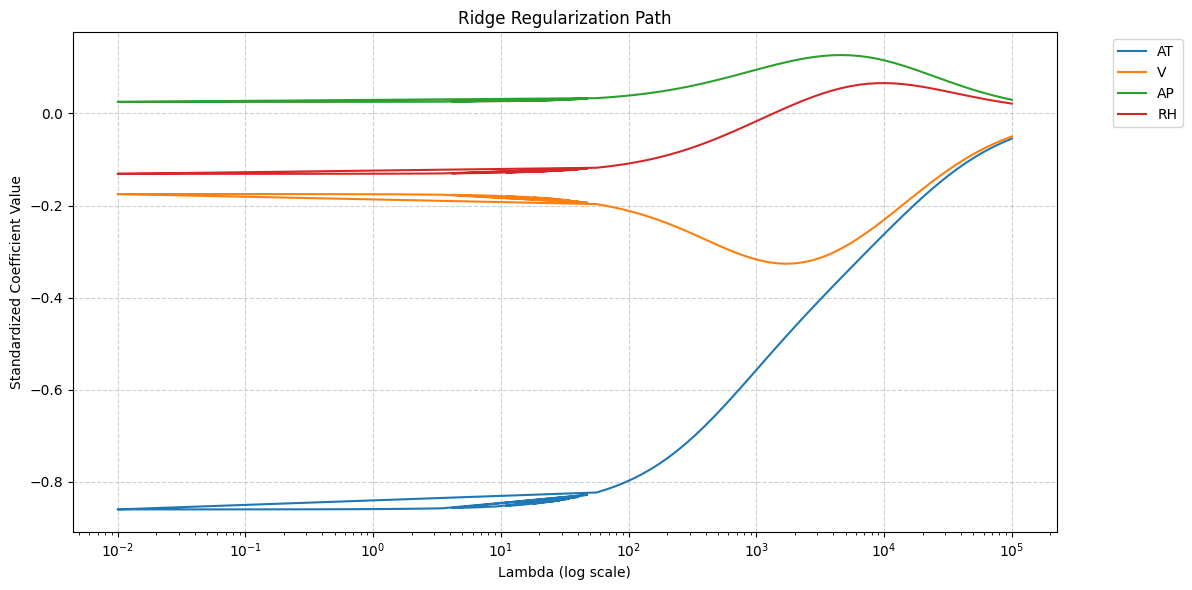

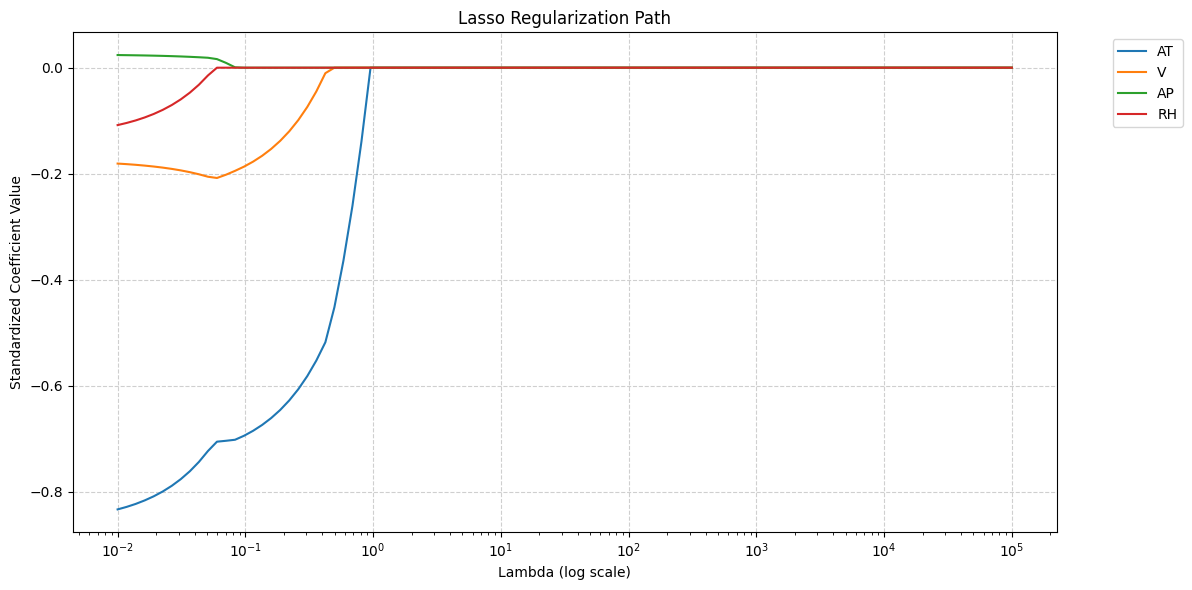

In [63]:
def plot_regularization_path(df_results, model_type, feature_names):
    plt.figure(figsize=(12, 6))

    # Convert the list of coefficients into separate columns for plotting
    coefs_df = pd.DataFrame(df_results['coef_value_(scaled_space)=standardized'].tolist(), columns=feature_names)

    for feature in feature_names:
        plt.plot(df_results['lambda'], coefs_df[feature], label=feature)

    plt.xscale('log')
    plt.xlabel('Lambda (log scale)')
    plt.ylabel('Standardized Coefficient Value')
    plt.title(f'{model_type} Regularization Path')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_regularization_path(ridge, 'Ridge', feature_names)
plot_regularization_path(lasso, 'Lasso', feature_names)


## Q5. Discussion

**1. What happens to coefficients as λ increases in Ridge vs Lasso?**

The coefficients in both cases approach 0. However, in Lasso, they quickly reach 0 and stay there, whie in Ridge the coefficients all gradually approach but never reach 0.

**2. Which regression is better under multicollinearity in IVs, and why?**

Ridge regression is better since it shrinks correlated features together evenly, and doesn't outright eliminate features like Lasso does.

**3. Which regression is better for feature selection, and why?**

Lasso is better for feature selection, since it drives the more irrelevant coefficents quickly to 0, allowing interpretation of only the most important features.